<a href="https://colab.research.google.com/github/mthu02/CV/blob/main/image_inpaiting_based_on_OMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from tensorflow.keras.preprocessing import image
img_path = "/content/drive/MyDrive/Colab Notebooks/OMP for image inpainting/Test_Fig2_Missing.png"
img = image.load_img(img_path)
img = image.img_to_array(img)

In [7]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import mean
from numpy.core.numeric import full
from numpy.lib.shape_base import kron
import string

In [8]:
def overlap_im2col(I, bb, overlap):
    #Extracts [bbxbb] patches from image I after every "overlap" pixels
    #
    #I: [N x M] image
    #bb: patch size
    #overlap: number of pixels betwwen consecutive patches
    #

    #get image size
    N, M = np.shape(I)

    #initialize X
    X = np.zeros([64,1])

    #calculate how many patches fit horizontally and vertically
    row = np.int((N - bb)/overlap)
    col = np.int((M - bb)/overlap)


    #iterate through patches
    for i in range(row+1):
        for j in range(col+1):
            #Take a patch with top-left corner at (i, j) and vectorise it
            X = np.concatenate((X, (I[(0+i*overlap):(bb+i*overlap), (0+j*overlap):(bb+j*overlap)]).reshape(bb*bb, 1)), axis = 1)
    return X[:,1:]

In [9]:
def overlap_col2im(X, mask, bb, overlap, im_size):
    """
    Recover overlapping (bb x bb) patches into an image reconstruction
    X: (bb^2 x N) matrix containing the vectorised signals
    Mask: (bb^2 x N) matrix containing the vectorised mask. Each column is the mask of the corresponding column of X
    bb: patch size
    overlap: number of pixels between consecutive patches
    im_size: tuple of original image dimensions
    """

    #get image dimensions
    N = np.shape(im_size)[0]
    M = np.shape(im_size)[1]
    
    #initialize the image
    I = np.zeros([N, M])

    #initialize the matrix that stores the cumulative signal used to calculate each pixcel
    S = np.zeros([N, M])

    #calculate how many patches 
    row = np.int((N - bb)/overlap)
    col = np.int((M - bb)/overlap)

    #iterate through patches and keep a counter to know what column of X to access next
    counter = -1
    for i in range(row+1):
        for j in range(col+1):
            counter = counter + 1
            #get x and y range of current patch
            x_patch = (np.linspace(0,bb-1,bb) + i*overlap).astype(int)
            y_patch = (np.linspace(0,bb-1,bb) + j*overlap).astype(int)

            #get existing patch
            existing_patch = I[x_patch[0]:x_patch[-1]+1, y_patch[0]:y_patch[-1]+1]
            
            #get current patch and calculate its signal strength
            current_patch = (X[:, counter]).reshape(bb, bb)
            signal = np.sum(np.sum(mask[:, counter] != 0))

            #update cumulative signal strength
            S[x_patch[0]:x_patch[-1]+1, y_patch[0]:y_patch[-1]+1] = S[x_patch[0]:x_patch[-1]+1, y_patch[0]:y_patch[-1]+1] + signal

            #upload patch
            I[x_patch[0]:x_patch[-1]+1, y_patch[0]:y_patch[-1]+1] = existing_patch + np.dot(current_patch, signal)

    # If a pixel was not covered by a single patch with signal, set its signal
    #value to 1, in order to prevent division by zero
    S[S==0] = 1

    #Divide each pixel by its corresponding cumulative signal coverage
    I = I/S

    return I

In [10]:
def interpolation(im_n, c):
    # Delaunay triangulation based interpolation
    # c=0 denotes preserved pixels
    x, y = np.nonzero(c==0)
    M, N = np.shape(im_n)
    x1, y1 = np.mgrid[:M, :N]
    im_r = griddata((x, y), im_n[np.nonzero(c==0)], (x1, y1), method='linear')
    #im_r = np.transpose(im_r)
    I = np.nonzero(np.isnan(im_r)==1)

    im_r[I] = 128
    return im_r

In [31]:
from scipy.sparse import csc_matrix
def omp_inpainting(D, X, mask, sigma, rc_min, max_coeff):
    # Perform sparse coding using a orthogonal matching pursuit(inpainting)
    #
    # Input
    # D: (n x K) unit norm atoms
    # X: (n x P) observations
    # mask: (n x P) mask denoting which observations are unknown
    # sigma: residual error stopping criterion, normalized by signal norm
    # rc_min: minimal residual correlation before stopping
    # max_coeff: maximal number of non-zero coefficients for signal
    #
    #Ouput
    # A: OMP coding
    n, P = np.shape(X)
    
    n, K = np.shape(D)
    A = csc_matrix((np.shape(D)[1], np.shape(X)[1]), dtype=float).toarray()
    for k in range(P):
        mpos = np.nonzero(mask[:, k])[0]
        Dict = D[mpos, :]
        W = 1/np.sqrt(np.diag(np.transpose(Dict) @ Dict))
        Dict = Dict @ np.diag(W)
        x = X[mpos, k]  # patch exclude mask

        residual = x
        indx = np.zeros([1,1])
        a = []
        DD = np.zeros([np.shape(Dict)[0], 1])
        currResNorm2 = np.linalg.norm(residual)
        j = 0
        rc_max = float('inf')
        threshold = np.linalg.norm(x) * sigma
        while np.linalg.norm(residual) > threshold and rc_max > rc_min and np.sum(a!=0) < max_coeff:
            j = j+1
            proj = np.transpose(Dict)@ residual
            rc_max = np.abs(proj).max(0)
            pos = np.abs(proj).argmax(0)
            DD = np.concatenate((DD, np.asarray(Dict[:, pos]).reshape(np.shape(Dict)[0],1)), axis = 1)
            indx = np.concatenate((indx, np.asarray(pos).reshape(1,1)), axis = 0)
            a = np.linalg.pinv(DD[:,1:]) @ x
            residual = x - DD[:,1:] @ a
        a = a.reshape(np.shape(a)[0],1)
        if len(indx[1:]) != 0:
            print(a)
            indx = indx[1:].astype(int)
            print(A[indx, k])
            A[indx,k] = a
            print(A[indx, k])
            A[:, k] = W * A[:, k]
            print("indx:",indx)
    return A

In [13]:
from scipy.interpolate import griddata

bb = 8
K=256
overlap=3
N, M, dim = np.shape(img)
img = np.double(img)
NN = 563
MM= 1001
img_new = np.zeros([NN,MM,3])
img_new[:N,:M,:] = img

mask = np.double((img_new[:,:,0] != 0))

In [14]:
blMask = overlap_im2col(mask, bb, overlap)

In [15]:
import skimage
from skimage import color
img_yuv = skimage.color.rgb2ycbcr(np.uint8(img_new))

In [16]:
img_yuv[:3,:3,0]

array([[151.71387059, 153.33361176,  16.        ],
       [137.01596471,  16.        ,  16.        ],
       [ 16.        ,  16.        , 157.94549412]])

In [17]:
img_inpaint_yuv = np.zeros([np.shape(img_yuv)[0], np.shape(img_yuv)[1],3])

img_inpaint_yuv[:,:,1] = interpolation(np.double(img_yuv[:,:,1]), np.double((img_new[:,:,1] == 0)))
img_inpaint_yuv[:,:,2] = interpolation(np.double(img_yuv[:,:,2]), np.double((img_new[:,:,2] == 0)))

In [18]:
IMin0 = np.double(img_yuv[:,:,0])

In [19]:
#The DCT dictionary
DCT = np.zeros([bb, np.int(np.sqrt(K))])

for k in range(np.int(np.sqrt(256))):
  V = np.cos(np.transpose(np.linspace(0,bb-1,bb)) * k * np.pi / np.sqrt(K))
  if k > 0: 
    V = V - np.mean(V)
  DCT[:, k] = V/np.linalg.norm(V)
DCT = np.kron(DCT, DCT)

In [20]:
    #Extracting the noisy image patches
    blkMatrixIm = overlap_im2col(IMin0, bb, overlap)
    sigma = 0.001   # 0.005  0.01
    rc_min = 0.01   # rc_min: minimal residual correlation before stopping pursuit
    max_coeff = 10  # max_coeff: sparsity constraint for signal representation 10

In [32]:
Coeff = omp_inpainting(DCT, blkMatrixIm * blMask, blMask, sigma, rc_min, max_coeff)

Streaming output truncated to the last 5000 lines.
 [0.]
 [0.]
 [0.]
 [0.]]
[[336.65605875]
 [ 81.38217587]
 [-52.13980579]
 [ 60.55596944]
 [ 32.0259296 ]
 [-23.00883276]
 [-19.76679506]
 [-19.46095062]
 [ 12.80251342]
 [-11.07647215]]
indx: [[  0]
 [ 34]
 [ 48]
 [ 69]
 [243]
 [ 13]
 [  6]
 [ 47]
 [112]
 [159]]
[[364.40626348]
 [-80.46244545]
 [-55.07189308]
 [-36.60475866]
 [ 34.92639498]
 [ 18.39909534]
 [ 16.87315427]
 [-14.50182657]
 [-17.7507756 ]
 [  9.32477968]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[364.40626348]
 [-80.46244545]
 [-55.07189308]
 [-36.60475866]
 [ 34.92639498]
 [ 18.39909534]
 [ 16.87315427]
 [-14.50182657]
 [-17.7507756 ]
 [  9.32477968]]
indx: [[  0]
 [ 32]
 [ 66]
 [ 85]
 [115]
 [ 53]
 [  4]
 [ 12]
 [164]
 [  9]]
[[387.44560102]
 [-59.07857013]
 [-39.90473572]
 [-19.99426741]
 [ 17.96167935]
 [ 17.18795145]
 [-14.00583088]
 [  7.67719326]
 [-11.71940361]
 [  6.96482784]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[38

In [ ]:
Coeff[:5,:5]

array([[  92,   27,   68, -110,  127],
       [   0,    0,    0,    0,  -68],
       [ -96,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0]], dtype=int8)

In [33]:
img_y = overlap_col2im(np.dot(DCT, Coeff), blMask, bb, overlap, img_new)


In [34]:
img_y[:5,:5]

array([[150.96085299, 152.07574228, 173.23184322, 230.51683622,
        229.78758084],
       [136.31272236, 165.37563847, 186.15533303, 173.10719457,
        201.28112104],
       [191.89372185, 171.45982897, 160.51384942, 175.96315324,
        193.6331795 ],
       [169.6893306 , 169.29215843, 158.36916635, 189.08209653,
        181.80017254],
       [174.46227867, 191.12900418, 185.86313904, 199.61106272,
        194.87090653]])

In [43]:
    img_y[img_y>255] = 255
    img_y[img_y<0] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[150.96085299 152.07574228 173.23184322 230.51683622 229.78758084]
 [136.31272236 165.37563847 186.15533303 173.10719457 201.28112104]
 [191.89372185 171.45982897 160.51384942 175.96315324 193.6331795 ]
 [169.6893306  169.29215843 158.36916635 189.08209653 181.80017254]
 [174.46227867 191.12900418 185.86313904 199.61106272 194.87090653]]
[[150 152 173 230 229]
 [136 165 186 173 201]
 [191 171 160 175 193]
 [169 169 158 189 181]
 [174 191 185 199 194]]
[[[0.6671498  0.59263999 0.6044047 ]
  [0.67268768 0.59817787 0.60602101]
  [0.7616399  0.6988948  0.70150918]
  [1.01556423 0.96458383 0.96196946]
  [1.00458331 0.96536763 0.95752449]]

 [[0.60071042 0.52620061 0.53404375]
  [0.73554851 0.65842433 0.66365309]
  [0.82897283 0.75446303 0.75642381]
  [0.76174131 0.69899621 0.69572824]
  [0.88323938 0.83127859 0.82441585]]

 [[0.84874415 0.78109709 0.79727356]
  [0.76918968 0.68487596 0.68291517]
  [0.71761    0.63525706 0.63525706]
  [0.78310379 0.70859398 0.70467242]
  [0.85713982 0.79243

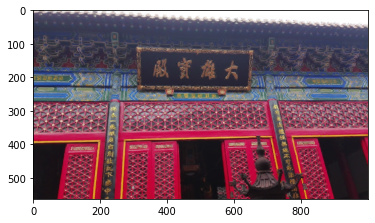

In [60]:
    img_inpaint_yuv[:,:,0] = img_y
    print(img_y[:5,:5])
    print(np.uint8(img_y[:5,:5]))
    img_inpaint_rgb = skimage.color.ycbcr2rgb((img_inpaint_yuv))
    img_out = img_inpaint_rgb[:N,:M,:]
    print(img_out[:5,:5])
    plt.imshow((img_out))
    plt.show()